# Introduction to Bayesian regularization

To many people, 'regularization' is just a pesky parameter to set in fitting algoritms, and 'Bayesian' means 'complicated and computationally expensive'. 

I hope to show that they can be much more than that, and show you how regularization can be a really neat way of dealing with over-parametrized problems, in particular in finance.

# Regularization in under-determined problems

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

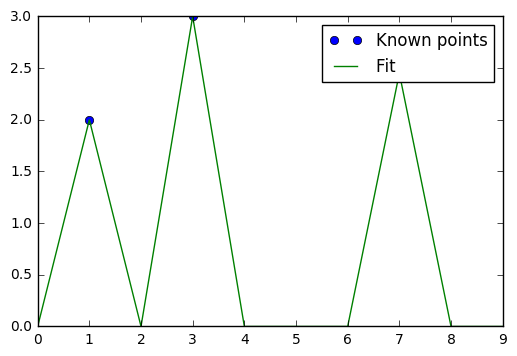

In [194]:
import numpy as np
# 10 points, know the values of 1,3, 7
inds = [1,3,7]
values = np.array([2,3,2.45])
A = np.eye(10)
# attempt 1, SVD/pseudoinverse:
p = np.linalg.pinv(A[inds,:]).dot(values)
x = A.dot(p)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

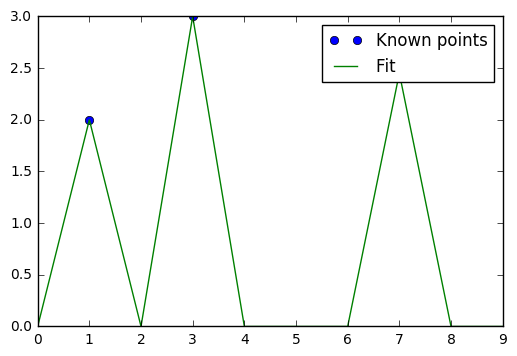

In [195]:
# attempt b, ridge regression:
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept = False, alpha = 1e-9)
reg.fit(A[inds,:], values)
x =A.dot(reg.coef_)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

It gets worse when the relationship between parameters and values is messier:

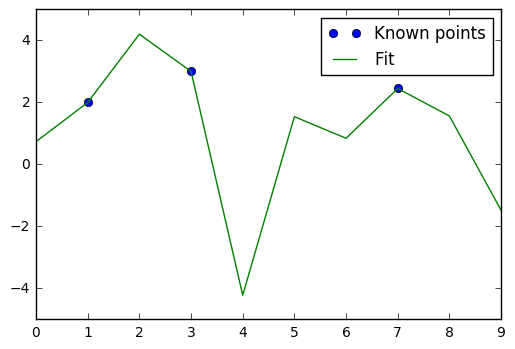

In [196]:
# A noisy matrix A:
Ar = np.eye(10) + np.random.normal(scale = 0.5, size = A.shape)
# attempt 1, SVD/pseudoinverse:
p = np.linalg.pinv(Ar[inds,:]).dot(values)
x = Ar.dot(p)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

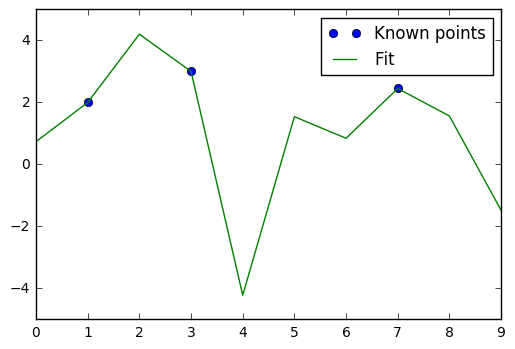

In [197]:
# attempt b, ridge regression:
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept = False, alpha = 1e-9)
reg.fit(Ar[inds,:], values)
x = Ar.dot(reg.coef_)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

Moral: with these methods, you're really at the mercy of your parametrization!

Let's take a step back and consider what's going on: we have more degrees of freedom than constraints. But that is a good thing! We can populate the extra degrees of freedom with any constraints we want, and that without affecting the original constraints noticeably.

Here's the problem we're trying to solve: (insert LaTeX):

In [198]:
# formulate the general regularized least squares problem, and explicit solution
def reg_coeffs(A, inds, R, y):
    R2 = R.dot(A)
    return np.linalg.inv(A[inds,:].T.dot(A[inds,:]) + R2.T.dot(R2)).dot(A[inds,:].T.dot(y))


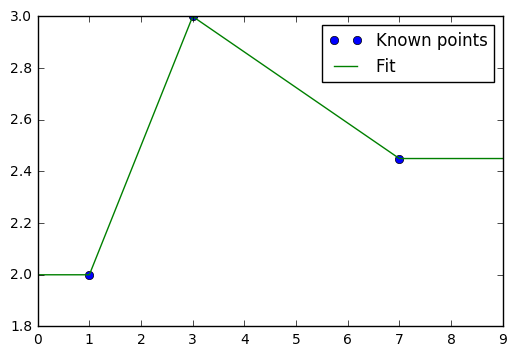

In [199]:
# let's take a first derivative matrix D, for example: 
D = np.zeros([10,10])
for i in range(9):
    D[i,i] = -1
    D[i,i+1] = 1
# plot solution for both A1 and A2: nice, no?
R = D
lam = 1e-4

p = reg_coeffs(A, inds, lam*R, values)
x = A.dot(p)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

That's already not bad, but a bit clunky - how about the second derivative?

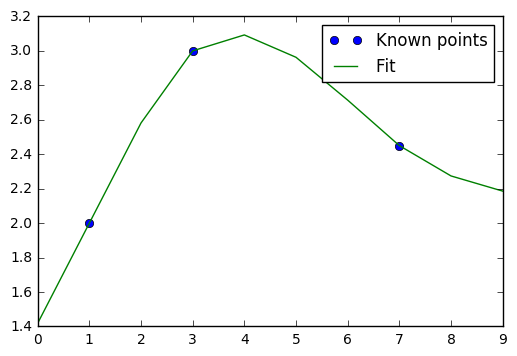

In [200]:
# let's take D^2: even nicer
R = D.dot(D)
lam = 1e-4
p = reg_coeffs(A, inds, lam*R, values)
x = A.dot(p)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

[ -3.35990786   1.54548444  -4.78293303   1.85863504   0.5143167
  -2.6593812    4.0546161    7.92171899   1.7224066   10.05911933]


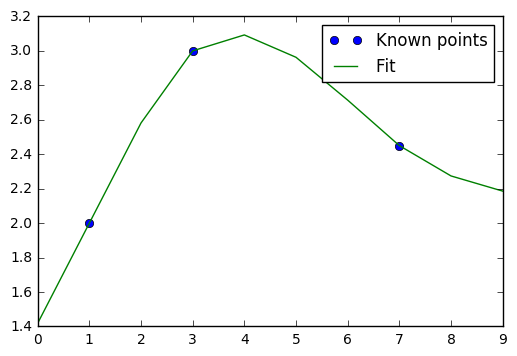

In [202]:
# That also works for a messy parametrization
R = D.dot(D)
lam = 1e-3
p = reg_coeffs(Ar,inds, lam*R, values)
print(p)
x = Ar.dot(p)
plt.plot(inds, values,'o')
plt.plot(x)
plt.legend(['Known points','Fit'])
plt.show()

Note that when the points are not equidistant, you need to formulate the derivative matrices accordingly

Now that was an example of creative regularization in under-determined problems. What does 'Bayesian' have to do with any of it?

# Regularization in fully determined problems

Suppose we're quoting some sort of financial instruments, for example option vols, without an underlying theory - just assuming that the curve should be 'smooth-ish'

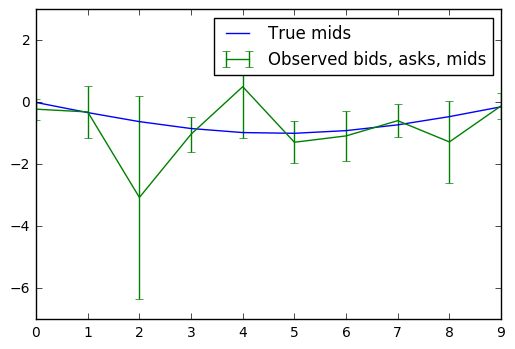

In [204]:
import math
# Generate and show bar chart with just mids for now
def get_curve_with_quotes(n):
    true_mids = np.array([ math.sin( -x/3) for x in range(10)])
    bid_dist = 0.1 + 0.5*np.abs(np.random.normal(size = true_mids.shape))
    ask_dist = 0.1 + 0.5*np.abs(np.random.normal(size = true_mids.shape))
    ask_dist[4] *= 7
    bid_dist[2] *= 5
    bid_dist[8] *= 5
    bids = true_mids - bid_dist
    asks = true_mids + ask_dist
    return true_mids, bids, asks

true_mids, bids, asks = get_curve_with_quotes(10)
mids = 0.5*(bids+asks)
plt.plot(true_mids)
plt.errorbar(range(10),mids, yerr = mids - bids)
plt.legend(['True mids', 'Observed bids, asks, mids'])
plt.show()


How do we fit a smooth curve to that?

We have two sets of constraints, observations and a-priori expectation of 'smoothiness'. How do we combine them?

That's what 'Bayesian' means, combining a priori expectations with new data.

What are the relative weights? Let's pretend we're in a Gaussian world and say our regularizer constraints are true with a certain standard deviation.

Fortunately, the observations bring their own std and that's the bid-ask spread!

Let's revisit the constraint equation, now with weight matrices added in.

In [208]:
# formulate the general regularized least squares problem, and explicit solution, using weights this time
def reg_coeffs(A, inds, R, y,yerr = None):
    if yerr is None:
        yerr = np.ones(y.shape)
    W = np.diag(1/(yerr*yerr))
    R2 = R.dot(A)
    new_var =  np.linalg.inv(A[inds,:].T.dot(W).dot(A[inds,:]) + R2.T.dot(R2))
    new_p = new_var.dot(A[inds,:].T.dot(W).dot(y))
    return new_p, new_var


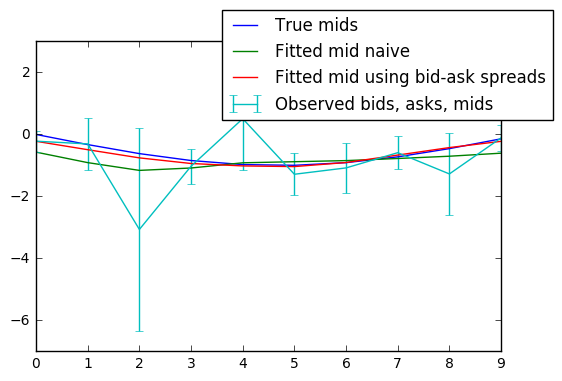

In [211]:
# plot the resulting solution with 3 different regularizer weights
# let's take D^2: even nicer
R = D.dot(D)
lam = 2

p, _ = reg_coeffs(A, range(10), lam*R, mids)
fit_mid = A.dot(p)

p2, var2 = reg_coeffs(A, range(10), lam*R, mids, mids-bids)
fit_mid2 = A.dot(p2)

plt.plot(true_mids)
plt.plot(fit_mid)
plt.plot(fit_mid2)
plt.errorbar(range(10),mids, yerr = mids - bids)
plt.legend(['True mids', 'Fitted mid naive',  'Fitted mid using bid-ask spreads', 'Observed bids, asks, mids'],
           bbox_to_anchor=(1, 1),bbox_transform=plt.gcf().transFigure)
plt.show()

Not only that, but the math for combination of Gaussians also gives us the standard deviation of these combined weights, namely inv(inv(var1) + inv(var2)).
These can be used as bid-ask spreads if we do our own quoting.

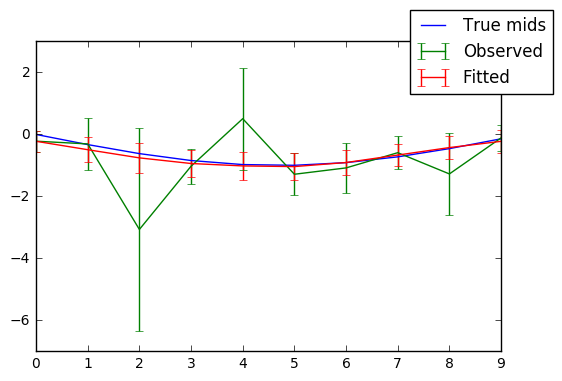

In [213]:
plt.plot(true_mids)
plt.errorbar(range(10),mids, yerr = mids - bids)
plt.errorbar(range(10),fit_mid2, yerr= np.sqrt(np.diag(var2)))
plt.legend(['True mids', 'Observed',  'Fitted'],
           bbox_to_anchor=(1, 1),bbox_transform=plt.gcf().transFigure)
plt.show()

Next question: how do we do this over time? Can we perhaps use the combined standard deviation as the initial std for the next step?

# Bayesian regularization over time

Now suppose we have a noisy random walk time series, with varying liquidity, and we want to determine a 'fair' value at any point in time

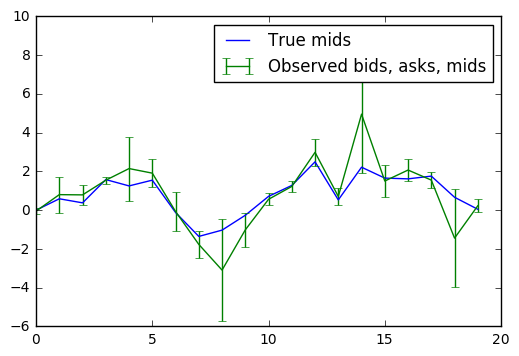

In [215]:
# create a random walk with some noise in bids/asks
ret = np.random.normal(size = 20)
true_mids = np.zeros(ret.shape)
for i in range(1,20):
    true_mids[i] = true_mids[i-1] + ret[i]
    
bid_dist = 0.1 + 0.5*np.abs(np.random.normal(size = true_mids.shape))
ask_dist = 0.1 + 0.5*np.abs(np.random.normal(size = true_mids.shape))
ask_dist[4] *= 7
bid_dist[9] *= 5
bid_dist[8] *= 5
ask_dist[14] *= 7
bid_dist[18]+=0.5
bid_dist[18] *= 5
bid_dist[15] *= 5
bids = true_mids - bid_dist
asks = true_mids + ask_dist
mids = 0.5*(bids+asks)
plt.plot(true_mids)
plt.errorbar(range(len(mids)),mids, yerr = mids - bids)
plt.legend(['True mids', 'Observed bids, asks, mids'])
plt.show()


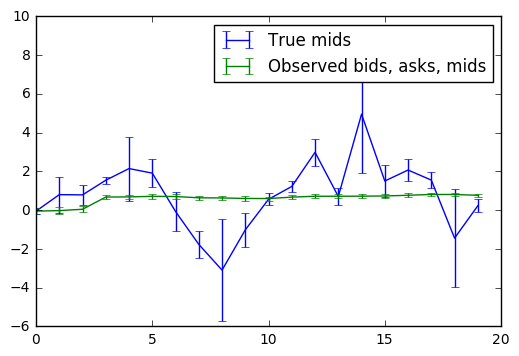

In [217]:
# first attempt formulas:
fit_values = np.zeros(mids.shape)
fit_stds = np.zeros(mids.shape)
pre_value = 0
pre_std = 1e6 # diffuse prior: we know nothing to begin with
for i, x in enumerate(zip(mids, mids-bids)):
    new_value = x[0]
    new_std = x[1]
    if i > 0:
        pre_value = fit_values[i-1]
        pre_std = fit_stds[i-1]
        
    post_std = 1/math.sqrt( 1/(pre_std*pre_std) + 1/(new_std*new_std))       
    post_value =(pre_value/(pre_std*pre_std) + new_value/(new_std*new_std))*post_std*post_std
    
    fit_values[i] = post_value
    fit_stds[i] = post_std

plt.errorbar(range(len(mids)),mids, yerr = mids - bids)
plt.errorbar(range(len(mids)),fit_values, yerr = fit_stds)
plt.legend(['True mids', 'Observed bids, asks, mids'])
plt.show()

What's going wrong here? We used the wrong process model! This would have worked great if the 'fair' value was constant, observed noisily - but the 'fair' value moves over time, we need to parametrize that movement in some way. 
What's the best candidate? Why, the variance \nu of the random walk!

Improved formulas

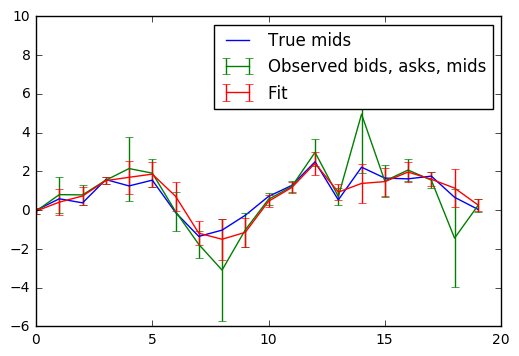

In [218]:
# now let's build in an uncertainty increase at every step
fit_values = np.zeros(mids.shape)
fit_stds = np.zeros(mids.shape)

pre_value = 0 
pre_std = 1e6 # this is called a diffuse prior

step_var = 1
for i, x in enumerate(zip(mids, mids-bids)):
    new_value = x[0]
    new_std = x[1]
    if i > 0:
        pre_value = fit_values[i-1]
        pre_std = fit_stds[i-1]
        
    pre_std = math.sqrt(pre_std*pre_std + step_var * step_var)
        
    post_std = 1/math.sqrt( 1/(pre_std*pre_std) + 1/(new_std*new_std))       
    post_value =(pre_value/(pre_std*pre_std) + new_value/(new_std*new_std))*post_std*post_std
    
    fit_values[i] = post_value
    fit_stds[i] = post_std
plt.plot(true_mids)
plt.errorbar(range(len(mids)),mids, yerr = mids - bids)
plt.errorbar(range(len(mids)),fit_values, yerr = fit_stds)
plt.legend(['True mids', 'Observed bids, asks, mids', 'Fit'])
plt.show()

That implementation works pretty well! 

This is actually a very simple example of a Kalman filter

# Brief introduction to the Kalman filter

https://en.wikipedia.org/wiki/Kalman_filter

Summary for our purposes, with regularization thrown in: 
Suppose the parameter vector p evolves over time as 
$$p_{t+1} = p_t + \epsilon_t, \epsilon_t \sim N(0, Q)$$
where Q is the step covariance matrix. 

Suppose at any point we have a best estimate $p^{post}_t$ including all data up to $t$, and an error covariance matrix $P^{post}_t$. 

Then at time step $t+1$ our prior estimate (before observing anything) will be 
$p^{pre}_{t+1} = p^{post}_t$ and its error variance will be $P^{pre}_{t+1} = P^{post}_t + Q$. 

Suppose we can observe $y = A\cdot p_{t+1} + \nu$, where $\nu \sim N(0, V_y)$
We can then derive $p^{post}_{t+1}$ as the solution $x$ to the problem

$$(A x - y )^T V_y^{-1} (A x - y ) + (p^{post}_t -x)^T (P^{pre}_{t+1})^{-1} (p^{post}_t -x) + (R A x)^2 \to min$$


The solution to that is simple linear algebra, see function below

In [237]:
# formulate the general regularized least squares problem, and explicit solution, using weights this time
def reg_coeffs_3(A, R, y, Q = None, p_prev = None, p_prev_var = None, 
                 p_step_var = None):
    if Q is None:
        Q = np.eye(len(y))
    if p_prev is None:
        p_prev = np.zeros(y.shape)
    if p_prev_var is None:
        p_prev_var = 1e9*np.eye(len(y)) # diffuse prior
    if p_step_var is None:
        p_prev_var = np.eye(len(y))

    R2 = R.dot(A) 
    W1 = np.linalg.inv(Q)
    W2 = np.linalg.inv(p_prev_var + p_step_var)
    
    next_var = np.linalg.inv(A.T.dot(W1).dot(A) + R2.T.dot(R2) + W2)
    x = A.T.dot(W1).dot(y) + W2.dot(p_prev)
    next_p = next_var.dot(x)
    return next_var.dot(x), next_var


Why is that fun? Because by just controlling the step variance and the regularization, we can control how our curve moves in response to observations.

In [238]:
# Initialize variables in this cell
true_mids, bids, asks = get_curve_with_quotes(9)
mids = 0.5*(bids+asks)

# will just observe one point on the curve, see how the curve updates in response
n = 2
new_values = mids.copy()
diag_var = 1e6*np.ones(mids.shape)
diag_var[n] = 0.01  # very precise observation
new_var = np.diag(diag_var)

# setup the prior curve values
pre_values= mids.copy()
pre_stds = 0.5*(asks-bids)
pre_var = np.diag(pre_stds*pre_stds)


i=0

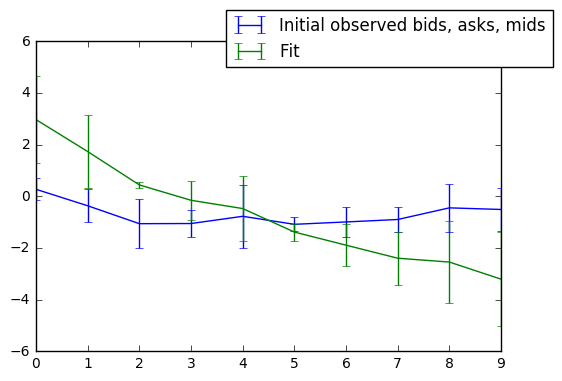

In [242]:
# Run this cell repeatedly to see how curve evolves over time

#first scenario: independent points, no observatios - see the regularization in action
if True:
    step_var = 0.1*np.eye(len(mids))
    new_var_used = 1e9*new_var
    R = 0.3*D.dot(D)

# second scenario: independent points, observe one point that keeps drifting up
if False:
    step_var = 0.1*np.eye(len(mids))
    new_var_used = new_var
    R = 0.3*D.dot(D)

# third scenario: points heavily correlated, observe one point that keeps drifing up
if False:
    step_var = np.ones(new_var.shape) + 0.001*np.eye(len(mids))
    new_var_used = new_var
    R = 0.3*D.dot(D)
    
# fourth scenario: dominant move is a tilt, observe one point that keeps drifing up
if False:
    eigen = np.array(range(10)).astype(float)
    eigen -= np.average(eigen)
    step_var =eigen[:,None]*eigen[None,:] + 0.001*np.eye(len(mids))
    new_var_used = new_var
    R = 0.001*D.dot(D)

if i > 0:
    pre_values = post_values
    pre_var = post_var
i+=1
        
post_values, post_var = reg_coeffs_3(A, R , new_values, new_var_used, 
                                    p_prev = pre_values, p_prev_var = pre_var, p_step_var = step_var)

# nudge the observation, to be used next time
new_values[n] += 0.5 

#plt.plot(true_mids)
plt.errorbar(range(len(mids)),mids, yerr = mids - bids)
plt.errorbar(range(len(mids)),post_values, yerr = np.sqrt(np.diag(post_var)))
plt.legend(['Initial observed bids, asks, mids', 'Fit'],
           bbox_to_anchor=(1, 1),bbox_transform=plt.gcf().transFigure)
plt.show()

# Advanced topics, briefly

## Hard inequality constraints

Can appear: most of you will still remember the time when interest rates were supposed to always be non-negative

With inequality constraints, the tidy connection to Gaussian distribution breaks down, but the quadratic cost approach works just fine: just add inequality constraints to that quadratic objective function.

The nice thing about QP is that the solver is guaranteed to find the **global** optimum!

## What to do when constraints multiply

If you have too many soft constraints, they start to get in each other's way - increasing one causes another to break, sometimes in unexpected ways. What to do?

*    **Hard equality constraints**: not least squares penalty, but force equations to be strictly true. Any QP solver will support those.

    *    A nice exercise: what relationship must one impose on the individual points, to force them to lie on a spline curve?

*    **Hierarchical fitting**: split the problem into several, solve each in turn, using the coefficients from originally solved problems as given

*    **Parametrization**: constrain the degrees of freedom by having your curve be a function of a small number of parameters (helps if the dependency on the parameters is linear-ish)

    * My favorite domain-agnostic parametrization is 'bandwidth-limited': sum of Gaussians on an evenly spaced grid with step of one standard deviation, model coefficients are the weights of the Gaussians

## Use of one observation in multple curves

For example when fitting vol curves, high delta instruments have a lot of info about the implied forward, and medium/low delta points have a lot of info about vol. By taking the bid/ask spread 'in forward space' to be the bid/ask spread of an instrument divided by its delta (and likewise for vol, divided by vega), and using these as confidence intervals, you automatically weight the points for an efficient fit

## Beyond random walks

One thing about prices is that they can jump! 

### 'No-memory' Kalman filter

If our market is liquid enough, we can set the step transition matrix to a very high variance, effectively making it similar to the very weak regularizer from the  start of the tutorial. This will mean the fit will adjust instantaneously to new points, so giving us faster reaction at the cost of more jitter

### Change detector algorithms

If the above approach is not good enough (for example, our process is very noisy, and has long periods of stable behavior followed by sudden jumps) we need to use a change detector algorithm. Pretty much all change detectors rely on some measure of variance, in addition to the actual values, so they're a great fit to our approach here

My favourite one is CUSUM (Wiki link). That can be used in an adaptive fitter in the following manner: 

1. Run two fitters, a reactive one and a stable one, and a change detector on the errors of the stable fitter.

2. Once the change detector triggers, you reset the current value of the stable detector to that of the reactive one, increase its estimate variance, and keep on going.
